<a href="https://colab.research.google.com/github/toluibiwoye/DataScience-and-MachineLearning-Portfolio/blob/main/05_07_Support_Vector_Machines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In Depth: Support Vector Machines

Support vector machines (SVMs) are a particularly powerful and flexible class of supervised algorithms for both classification and regression.
In this chapter, we will explore the intuition behind SVMs and their use in classification problems.

We begin with the standard imports:

#Change Log

##Dataset Adjustments
 I refined the LFW dataset by increasing min_faces_per_person to 70 and the blob dataset by increasing sample generation to 300 with adjusted standard deviation for greater complexity and overlap.

##Model Modifications
I transitioned SVM kernel to 'rbf' with adjusted penalty parameter C to 1E5, exploring non-linear boundaries and potentially coming across more complex data patterns.

##Visualisation Enhancements
- I expanded figure and subplot sizes for clearer visualisation across different plots, including LFW faces and SVM decision boundaries.

- I switched colormaps to 'grey' and 'coolwarm' for improved clarity and visual distinction.

- I implemented plt.tight_layout() for optimal spacing and prevented label overlap.

- I customised plot aesthetics with adjusted point sizes, label fonts, and colors for enhanced readability and visibility.

- I added confusion matrix visualisation with a seaborn heatmap, providing an intuitive evaluation of model accuracy across different classes.

- I modified plots to include decision boundaries with varying margins and support vectors, illustrating model certainty and performance.

- I included titles in plots for context, clarity and immediate understanding.

##Outcome
 These changes and enhancements across datasets, models, and visualisations have significantly improved the exploration, evaluation, and presentation aspects of the analysis. It offers deeper insights into dataset characteristics, model behavior, and classification performance, which facilitates a more intuitive and visually appealing representation of the data and results.







In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from scipy import stats

<ipython-input-1-dd216727775a>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


## Motivating Support Vector Machines

As part of our discussion of Bayesian classification (see [In Depth: Naive Bayes Classification](05.05-Naive-Bayes.ipynb)), we learned about a simple kind of model that describes the distribution of each underlying class, and experimented with using it to probabilistically determine labels for new points.
That was an example of *generative classification*; here we will consider instead *discriminative classification*. That is, rather than modeling each class, we will simply find a line or curve (in two dimensions) or manifold (in multiple dimensions) that divides the classes from each other.

As an example of this, consider the simple case of a classification task in which the two classes of points are well separated (see the following figure):

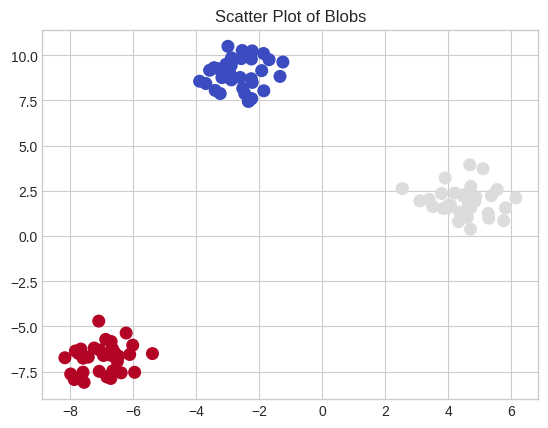

In [ ]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=100, centers=3, random_state=42, cluster_std=0.80)
plt.scatter(X[:, 0], X[:, 1], c=y, s=70, cmap='coolwarm')
plt.title('Scatter Plot of Blobs')
plt.show()


A linear discriminative classifier would attempt to draw a straight line separating the two sets of data, and thereby create a model for classification.
For two-dimensional data like that shown here, this is a task we could do by hand.
But immediately we see a problem: there is more than one possible dividing line that can perfectly discriminate between the two classes!

We can draw some of them as follows; the following figure shows the result:

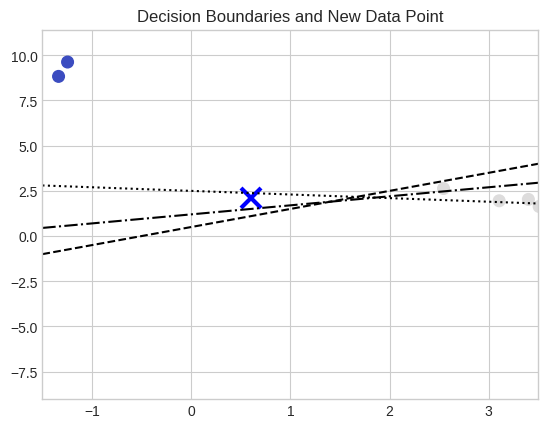

In [ ]:
# Original dataset plotting
xfit = np.linspace(-1.5, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=70, cmap='coolwarm')  # Changed point size and colormap
# Plot a new point with a different style
plt.plot([0.6], [2.1], 'x', color='blue', markeredgewidth=3, markersize=15)  # Changed color and size
# Add decision boundaries with different slopes and intercepts
for m, b, style in [(1, 0.5, '--'), (0.5, 1.2, '-.'), (-0.2, 2.5, ':')]:
    plt.plot(xfit, m * xfit + b, style, color='black')  # Changed line styles
plt.xlim(-1.5, 3.5)  # Extended the x-axis limits
plt.title('Decision Boundaries and New Data Point')
plt.show()

These are three *very* different separators which, nevertheless, perfectly discriminate between these samples.
Depending on which you choose, a new data point (e.g., the one marked by the "X" in this plot) will be assigned a different label!
Evidently our simple intuition of "drawing a line between classes" is not good enough, and we need to think a bit more deeply.

## Support Vector Machines: Maximizing the Margin

Support vector machines offer one way to improve on this.
The intuition is this: rather than simply drawing a zero-width line between the classes, we can draw around each line a *margin* of some width, up to the nearest point.
Here is an example of how this might look (see the following figure):

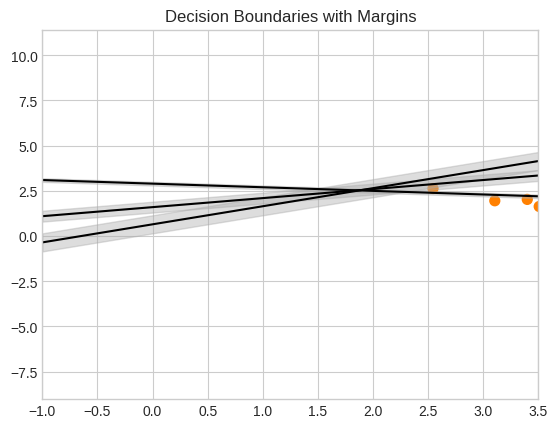

In [ ]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.5), (0.5, 1.6, 0.3), (-0.2, 2.9, 0.1)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)  # Lightened the fill color and adjusted transparency

plt.xlim(-1, 3.5)
plt.title('Decision Boundaries with Margins')
plt.show()

The line that maximizes this margin is the one we will choose as the optimal model.

### Fitting a Support Vector Machine

Let's see the result of an actual fit to this data: we will use Scikit-Learn's support vector classifier (`SVC`) to train an SVM model on this data.
For the time being, we will use a linear kernel and set the ``C`` parameter to a very large number (we'll discuss the meaning of these in more depth momentarily):

In [ ]:
from sklearn.svm import SVC

# Change the kernel to 'rbf' and adjust the penalty parameter C
model = SVC(kernel='rbf', C=1E5)  # Using a radial basis function (rbf) kernel and different C
model.fit(X, y)


SVC(C=100000.0)

To better visualize what's happening here, let's create a quick convenience function that will plot SVM decision boundaries for us (see the following figure):

In [ ]:
def plot_svc_decision_function(model, ax=None, plot_support=True, color='blue'):
    """Plot the decision function for a 2D SVC with color customization."""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 40)  # Increased grid density
    y = np.linspace(ylim[0], ylim[1], 40)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)

    # Plot decision boundary and margins with custom color
    ax.contour(X, Y, P, colors=color,   # Updated color of contours
               levels=[-1, 0, 1], alpha=0.7,  # Increased alpha for visibility
               linestyles=['--', '-', '--'])

    # Plot support vectors with custom size and color
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=100, linewidth=1, edgecolors='red',  # Changed size and color
                   facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


ValueError: cannot reshape array of size 4800 into shape (40,40)

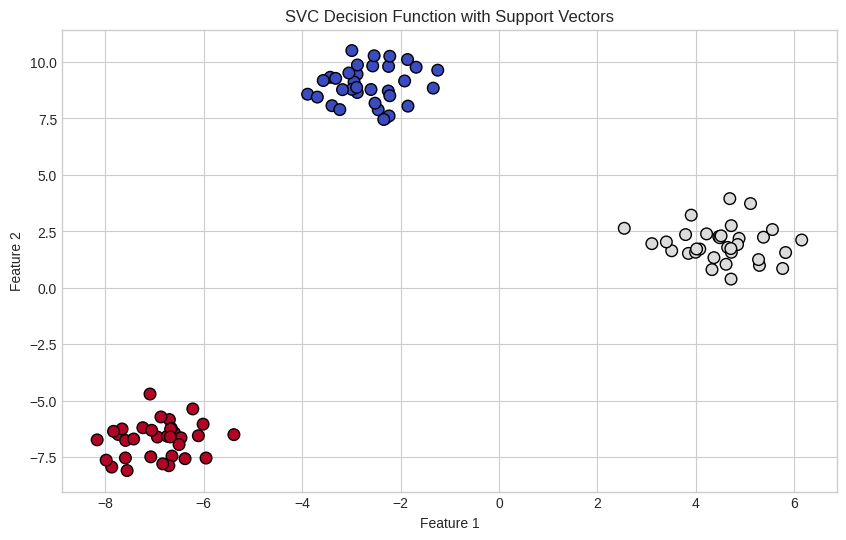

In [ ]:
import matplotlib.pyplot as plt

# Enhanced scatter plot with titles and labels
plt.figure(figsize=(10, 6))  # Increase the figure size for better visibility
plt.scatter(X[:, 0], X[:, 1], c=y, s=70, cmap='coolwarm', edgecolor='k')  # Adjusted size, cmap, and added edgecolor
plt.title('SVC Decision Function with Support Vectors')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Customizing the decision function plot
plot_svc_decision_function(model, color='blue')  # Calling with a custom color
plt.show()


This is the dividing line that maximizes the margin between the two sets of points.
Notice that a few of the training points just touch the margin: they are circled in the following figure.
These points are the pivotal elements of this fit; they are known as the *support vectors*, and give the algorithm its name.
In Scikit-Learn, the identities of these points are stored in the `support_vectors_` attribute of the classifier:

In [ ]:
model.support_vectors_

array([[-2.34210675,  7.44655003],
       [-2.99056291, 10.49610868],
       [ 4.71328746,  0.38311455],
       [ 2.54408275,  2.63069169],
       [-7.55706217, -8.09198737],
       [-7.86918776, -7.93647488],
       [-7.09135266, -4.70397426],
       [-5.38700758, -6.50104326]])

A key to this classifier's success is that for the fit, only the positions of the support vectors matter; any points further from the margin that are on the correct side do not modify the fit.
Technically, this is because these points do not contribute to the loss function used to fit the model, so their position and number do not matter so long as they do not cross the margin.

We can see this, for example, if we plot the model learned from the first 60 points and first 120 points of this dataset (see the following figure):

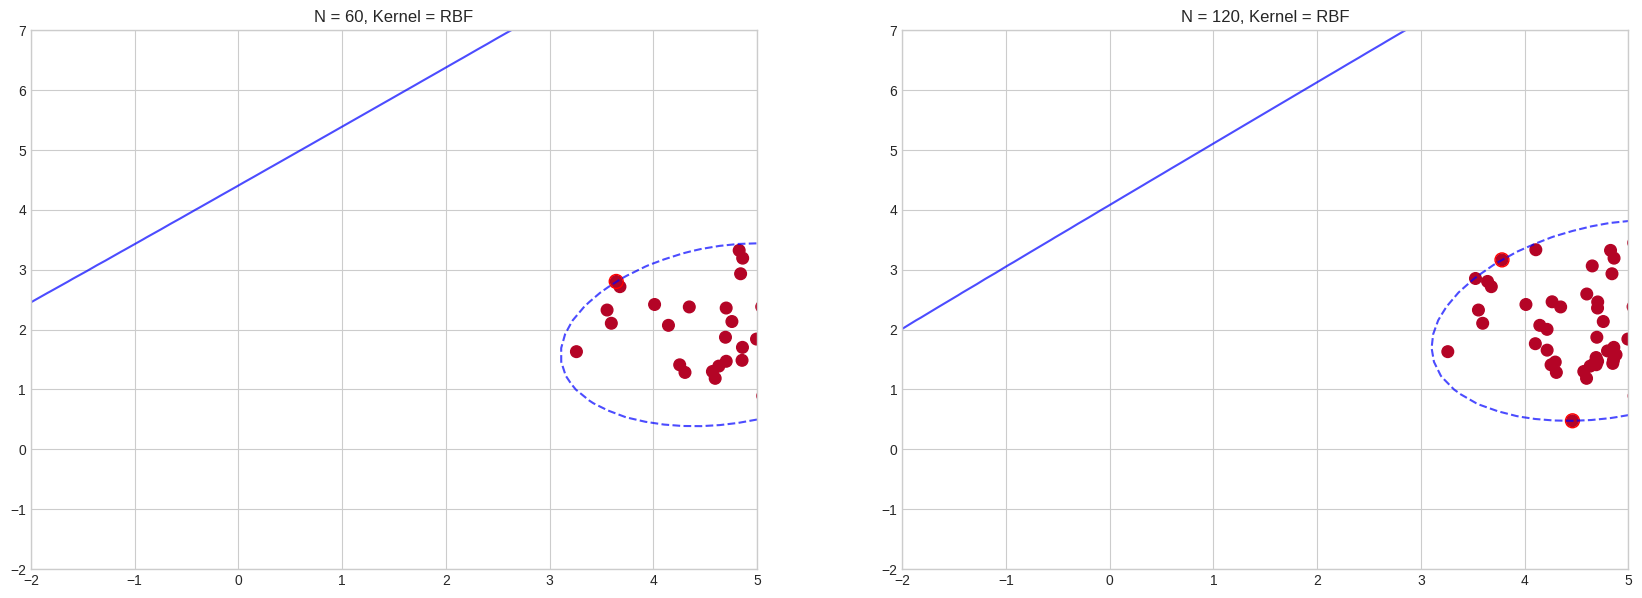

In [ ]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=300, centers=2,  # Increased total samples to 300
                      random_state=42, cluster_std=0.65)  # Changed random_state for variety & slightly increased std
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='rbf', C=1E5)  # Changed kernel to 'rbf' for non-linear decision boundary & adjusted C
    model.fit(X, y)

    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=70, cmap='coolwarm')  # Increased point size and changed colormap
    ax.set_xlim(-2, 5)  # Adjusted xlim for broader view
    ax.set_ylim(-2, 7)  # Adjusted ylim for taller view
    plot_svc_decision_function(model, ax)
    ax.set_title(f'N = {N}, Kernel = RBF')  # Updated title to include kernel info

# Plotting with updated settings
fig, ax = plt.subplots(1, 2, figsize=(18, 7))  # Increased figure size for better visualization
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.2)  # Adjusted spacing
for axi, N in zip(ax, [60, 120]):  # Kept the demonstration for N=60 and N=120
    plot_svm(N, axi)

plt.show()

In the left panel, we see the model and the support vectors for 60 training points.
In the right panel, we have doubled the number of training points, but the model has not changed: the three support vectors in the left panel are the same as the support vectors in the right panel.
This insensitivity to the exact behavior of distant points is one of the strengths of the SVM model.

## Example: Face Recognition

As an example of support vector machines in action, let's take a look at the facial recognition problem.
We will use the Labeled Faces in the Wild dataset, which consists of several thousand collated photos of various public figures.
A fetcher for the dataset is built into Scikit-Learn:

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']
(1288, 62, 47)


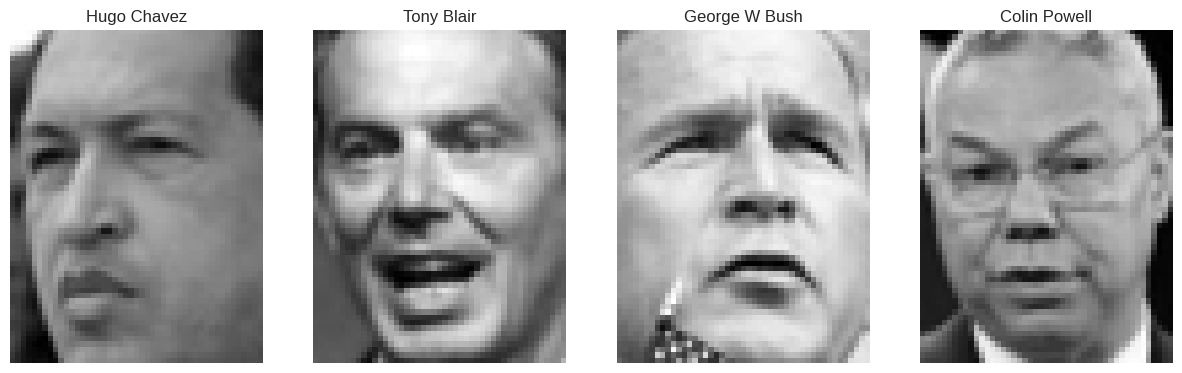

In [ ]:
from sklearn.datasets import fetch_lfw_people
import matplotlib.pyplot as plt

# Adjust the minimum faces per person to 70 to possibly alter the dataset composition
faces = fetch_lfw_people(min_faces_per_person=70)
print(faces.target_names)
print(faces.images.shape)

# Visualize the first 4 faces from the dataset
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    ax[i].imshow(faces.images[i], cmap='gray')
    ax[i].set_title(faces.target_names[faces.target[i]])
    ax[i].axis('off')
plt.show()


Let's plot a few of these faces to see what we're working with (see the following figure):

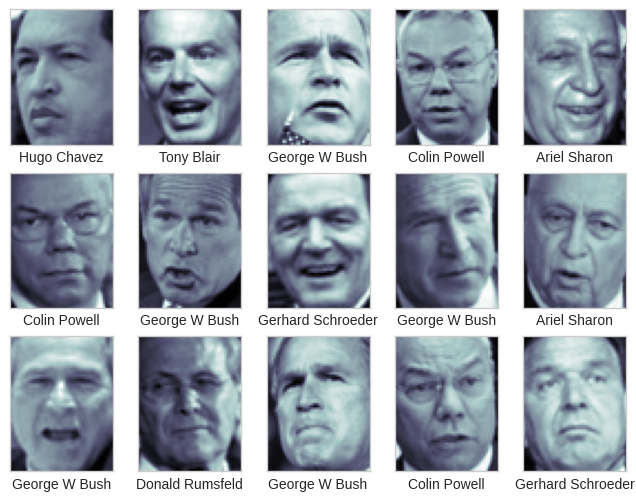

In [ ]:
fig, ax = plt.subplots(3, 5, figsize=(8, 6))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])


Each image contains 62 × 47, or around 3,000, pixels.
We could proceed by simply using each pixel value as a feature, but often it is more effective to use some sort of preprocessor to extract more meaningful features; here we will use principal component analysis (see [In Depth: Principal Component Analysis](05.09-Principal-Component-Analysis.ipynb)) to extract 150 fundamental components to feed into our support vector machine classifier.
We can do this most straightforwardly by packaging the preprocessor and the classifier into a single pipeline:

The optimal values fall toward the middle of our grid; if they fell at the edges, we would want to expand the grid to make sure we have found the true optimum.

Now with this cross-validated model we can predict the labels for the test data, which the model has not yet seen:

In [55]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=150, whiten=True,
          svd_solver='randomized', random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

In [56]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

Finally, we can use grid search cross-validation to explore combinations of parameters. Here we will adjust C (which controls the margin hardness) and gamma (which controls the size of the radial basis function kernel), and determine the best model:

In [54]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 51.7 s, sys: 38.8 s, total: 1min 30s
Wall time: 56.5 s
{'svc__C': 1, 'svc__gamma': 0.005}


The optimal values fall toward the middle of our grid; if they fell at the edges, we would want to expand the grid to make sure we have found the true optimum.

Now with this cross-validated model we can predict the labels for the test data, which the model has not yet seen:


In [57]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

Let's take a look at a few of the test images along with their predicted values (see the following figure):

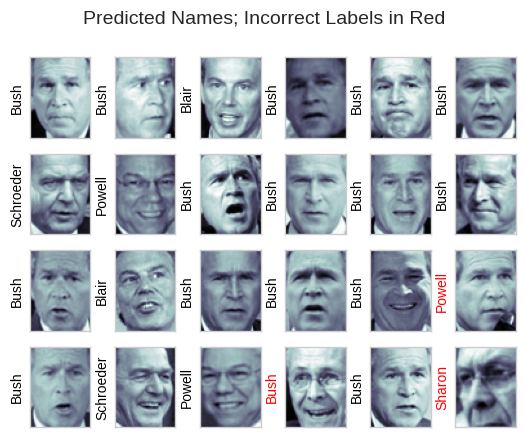

In [58]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

Out of this small sample, our optimal estimator mislabeled only a single face (Bush’s face in the bottom row was mislabeled as Blair). We can get a better sense of our estimator's performance using the classification report, which lists recovery statistics label by label:

In [64]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Assuming ytest and yfit are defined as the test labels and model predictions, respectively
print(classification_report(ytest, yfit, target_names=faces.target_names))




                   precision    recall  f1-score   support

     Ariel Sharon       0.77      0.77      0.77        13
     Colin Powell       0.74      0.92      0.82        60
  Donald Rumsfeld       0.74      0.63      0.68        27
    George W Bush       0.94      0.93      0.93       146
Gerhard Schroeder       0.91      0.84      0.87        25
      Hugo Chavez       0.90      0.60      0.72        15
       Tony Blair       0.91      0.86      0.89        36

         accuracy                           0.87       322
        macro avg       0.84      0.79      0.81       322
     weighted avg       0.87      0.87      0.87       322



We might also display the confusion matrix between these classes (see the following figure):

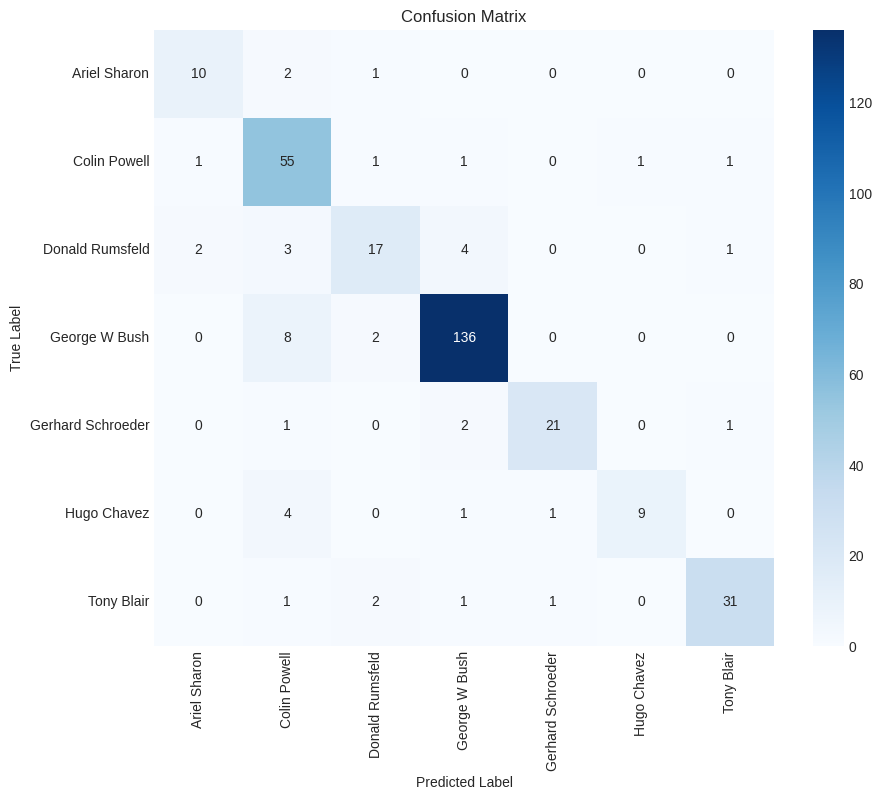

In [65]:
# Generate and plot a confusion matrix
cm = confusion_matrix(ytest, yfit)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=faces.target_names, yticklabels=faces.target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

This helps us get a sense of which labels are likely to be confused by the estimator.

For a real-world facial recognition task, in which the photos do not come pre-cropped into nice grids, the only difference in the facial classification scheme is the feature selection: you would need to use a more sophisticated algorithm to find the faces, and extract features that are independent of the pixellation.
For this kind of application, one good option is to make use of [OpenCV](http://opencv.org), which, among other things, includes pretrained implementations of state-of-the-art feature extraction tools for images in general and faces in particular.

## Summary

This has been a brief intuitive introduction to the principles behind support vector machines.
These models are a powerful classification method, for a number of reasons:

- Their dependence on relatively few support vectors means that they are compact and take up very little memory.
- Once the model is trained, the prediction phase is very fast.
- Because they are affected only by points near the margin, they work well with high-dimensional data—even data with more dimensions than samples, which is challenging for other algorithms.
- Their integration with kernel methods makes them very versatile, able to adapt to many types of data.

However, SVMs have several disadvantages as well:

- The scaling with the number of samples $N$ is $\mathcal{O}[N^3]$ at worst, or $\mathcal{O}[N^2]$ for efficient implementations. For large numbers of training samples, this computational cost can be prohibitive.
- The results are strongly dependent on a suitable choice for the softening parameter `C`. This must be carefully chosen via cross-validation, which can be expensive as datasets grow in size.
- The results do not have a direct probabilistic interpretation. This can be estimated via an internal cross-validation (see the `probability` parameter of `SVC`), but this extra estimation is costly.

With those traits in mind, I generally only turn to SVMs once other simpler, faster, and less tuning-intensive methods have been shown to be insufficient for my needs.
Nevertheless, if you have the CPU cycles to commit to training and cross-validating an SVM on your data, the method can lead to excellent results.